# Shell APD Learning eXchange DnA Notebook
## Predicting power usage in the eastern United States

## PJM Hourly Energy Consumption Data

PJM is a regional transmission organization in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

We will be using hourly power consumption data from PJM's East grid. This data set ranges from 2002-2018. The data came from PJM's website and are given in megawatts (MW).

## Overview:

#### Day 1

0. [Introduction](#intro)
1. [Import packages](#setup)
2. [Get the data](#data)
3. [Explore the data](#explore)
4. [Split train and test sets](#traintest)
5. [Regression - Predict energy usage](#model)
    - [Linear regression](#linear)
    - [Gradient-boosted trees](#xgbreg)
    
#### Day 2
6. [Engineer new features](#featureengineer)
7. [Clean the dataset](#cleaning)
8. [Retrain your model with new features](#modelnew)
9. [Classification - Predict weekend and weekday](#classification)    
10. [Cluster - Group the data](#clustering)
11. [Next steps](#nextsteps)


<br><br/>


REGRESSION | CLASSIFICATION | CLUSTERING
- | - | -
<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/LR.png?raw=true" width="390"> | <img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/CLASS1.png?raw=true" width="390"> | <img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/clustering.png?raw=true" width="320">


# 1. Import some python libararies and define functions we'll need <a class="anchor" id="setup"></a>

In [1]:
%%capture

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
import seaborn as sns
import math
from datetime import datetime

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')

# 2. Download the data to our notebook <a class="anchor" id="data"></a>


In [2]:
url = 'https://github.com/robmoratore/ShellDnA/raw/master/data/PJM_Load.csv'
df_full = pd.read_csv(url, sep = ',', date_parser=["date"])
df_full.index = df_full["date"]
df_full = df_full.drop(columns=['date'])
pjme = df_full[['load', 'dayofyear']]

# 3. Explore the data <a class="anchor" id="explore"></a>

### Let's look at the first few rows of the dataset

In [3]:
pjme.head()

,load,dayofyear
date,,
2002-01-01 01:00:00,30393,1
2002-01-01 02:00:00,29265,1
2002-01-01 03:00:00,28357,1
2002-01-01 04:00:00,27899,1
2002-01-01 05:00:00,28057,1


In [4]:
pjme.index = pd.DatetimeIndex(pjme.index)

### Plot energy usage over time

[Text(0,0.5,'Energy'), Text(0.5,0,'Time')]

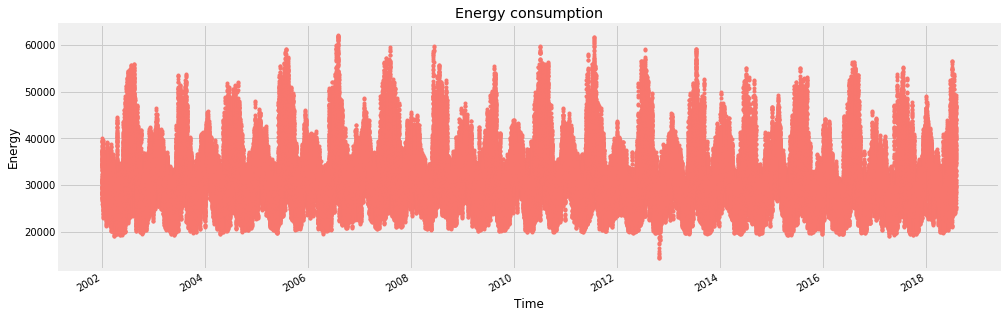

In [5]:
_ = pjme["load"].plot(style='.', figsize=(15,5), color=color_pal[0], title='Energy consumption')
_.set(xlabel="Time", ylabel="Energy")

# 4. Split the train and testing sets <a class="anchor" id="traintest"></a>

We do that to ensure our model is able to generalize. That means, perform well on unseen data. If we train and test using the same data, the model will memorize that specific output and not learn it.

We will use the data from 2015 on as our test set.

![alt](https://github.com/robmoratore/ShellDnA/blob/master/data/images/train_test.png?raw=true)

In [6]:
split_date = '2015-01-01'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

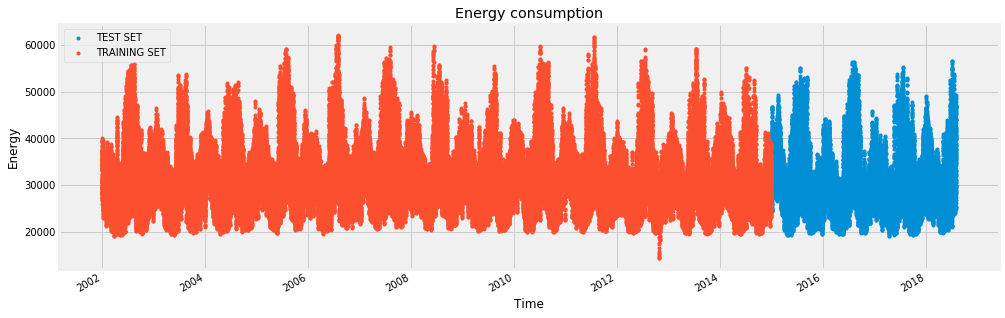

In [7]:
ax = pd.DataFrame(pjme_test["load"]) \
    .rename(columns={'load': 'TEST SET'}) \
    .join(pd.DataFrame(pjme_train["load"]).rename(columns={'load': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Energy consumption', style='.')

_ = ax.set(xlabel="Time", ylabel="Energy")

# 5. Regression - Can we predict energy use for a given hour? <a class="anchor" id="model"></a>

## $$ \hat{y}(w,x) = w_0 + w_1 x_1 + w_2 x_2 + ... + w_p x_p $$

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/bias.png?raw=true" />

## 5.1 Start with a simple model - Linear Regression <a class="anchor" id="linear"></a>

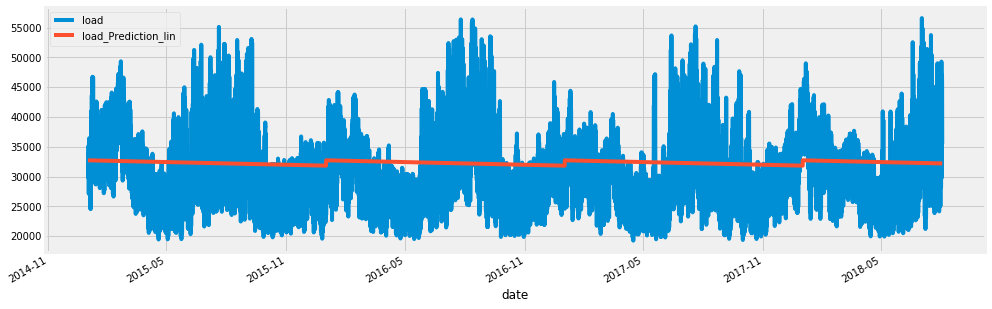

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(pjme_train["dayofyear"].values.reshape(-1, 1), pjme_train["load"].values.reshape(-1, 1))
pjme_test['load_Prediction_lin'] = lin_reg.predict(pjme_test["dayofyear"].values.reshape(-1, 1))
_ = pjme_test[['load','load_Prediction_lin']].plot(figsize=(15, 5))

### Check how well our model performs
Which error metrics would you choose?

In [9]:
mse = mean_squared_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin'])
print ("The Mean Squared Error (MSE) is ", round(mse, 2) , "MW^2")
print ("The Root Mean Squared Error (RMSE) is ", round(np.sqrt(mse), 2), "MW")
print ("The Mean Absolute Error (MAE) is ", round(mean_absolute_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin']), 2), "MW")
print ("The Mean Absolute Percentage Error is ", round(mean_absolute_percentage_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_lin']), 2), "%")
print ("The R^2 (coefficient of determination) regression score is ", round(r2_score(y_true=pjme_test['load'],y_pred=pjme_test['load_Prediction_lin']), 2))

The Mean Squared Error (MSE) is  42420390.48 MW^2
The Root Mean Squared Error (RMSE) is  6513.09 MW
The Mean Absolute Error (MAE) is  5242.38 MW
The Mean Absolute Percentage Error is  17.6 %
The R^2 (coefficient of determination) regression score is  -0.02


## 5.2 Get fancy with some Machine Learning - XGBoost Model <a class="anchor" id="xgbreg"></a>

This is one of the cleverest ways of combining multiple decision trees. Here, instead of having one single tree responsible for all the decisions, you use many trees on sequence. That means, the next tree does not try to predict the final result but the error of the previous tree. When you add all trees together, the results are generally very good

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/xgb_reg.png?raw=true" width="600">
<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/xgb2.png?raw=true" width="800">

Can you think of other ways of using multiple decision trees to make predictions?

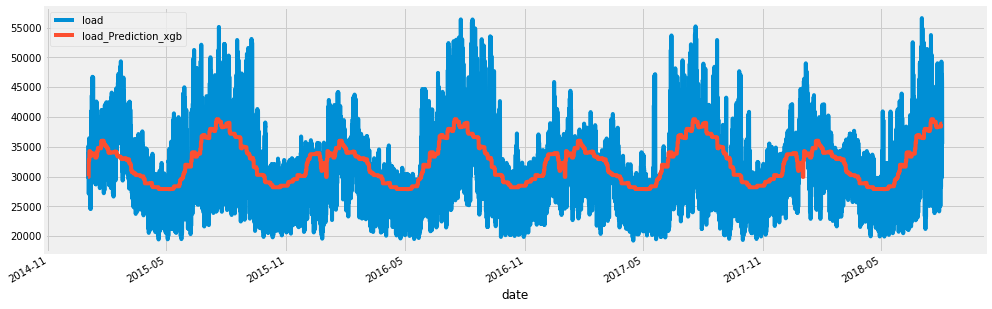

In [10]:
include_variables = "dayofyear"
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(pjme_train[include_variables].values.reshape(-1, 1), pjme_train["load"].values.reshape(-1, 1))
pjme_test['load_Prediction_xgb'] = reg.predict(pjme_test[include_variables].values.reshape(-1, 1))
_ = pjme_test[['load','load_Prediction_xgb']].plot(figsize=(15, 5))

### Check how well our model performs

In [11]:
mse = mean_squared_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb'])
print ("The Mean Squared Error (MSE) is ", round(mse, 2), "MW^2")
print ("The Root Mean Squared Error (RMSE) is ", round(np.sqrt(mse), 2), "MW")
print ("The Mean Absolute Error (MAE) is ", round(mean_absolute_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb']), 2), "MW")
print ("The Mean Absolute Percentage Error is ", round(mean_absolute_percentage_error(y_true=pjme_test['load'], y_pred=pjme_test['load_Prediction_xgb']), 2), "%")
print ("The R^2 (coefficient of determination) regression score is ", round(r2_score(y_true=pjme_test['load'],y_pred=pjme_test['load_Prediction_xgb']), 2))

The Mean Squared Error (MSE) is  31417302.8 MW^2
The Root Mean Squared Error (RMSE) is  5605.11 MW
The Mean Absolute Error (MAE) is  4386.75 MW
The Mean Absolute Percentage Error is  14.78 %
The R^2 (coefficient of determination) regression score is  0.24


# 6. Engineer New Features <a class="anchor" id="featureengineer"></a>

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/pipeline.png?raw=true" width="1200">


Here, we can create features to distinguish a seashell image from the Shell's logo. For example, we can have a feature "red" that represents the amount of red pixels present in the picture (in %, for example). That feature, will help the machine learning model to distinguish between the two images. Another example is the image's symmetry (yes/no).


<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/shell.png?raw=true" width="700">



### Which features would you create to help predict load?

### We created some features ahead of time for you 

In [12]:
df_full.head().round(2)

,load,load_1h,loadmean_6h,loadmean_12h,loadmean_24h,load_peak,year,quarter,month,weekofyear,dayofyear,dayofmonth,dayofweek,hour,daytime,weekend,holiday,businessday,season,temp,precipitation
date,,,,,,,,,,,,,,,,,,,,,
2002-01-01 01:00:00,30393,NaN,NaN,NaN,NaN,30578.83,2002,1,1,1,1,1,3,1,0,0,1,0,1,21.2,0.0
2002-01-01 02:00:00,29265,30393.0,NaN,NaN,NaN,29661.00,2002,1,1,1,1,1,3,2,0,0,1,0,1,21.2,0.0
2002-01-01 03:00:00,28357,29265.0,NaN,NaN,NaN,31142.89,2002,1,1,1,1,1,3,3,0,0,1,0,1,21.2,0.0
2002-01-01 04:00:00,27899,28357.0,NaN,NaN,NaN,28939.30,2002,1,1,1,1,1,3,4,0,0,1,0,1,21.2,0.0
2002-01-01 05:00:00,28057,27899.0,NaN,NaN,NaN,29395.44,2002,1,1,1,1,1,3,5,0,0,1,0,1,21.2,0.0


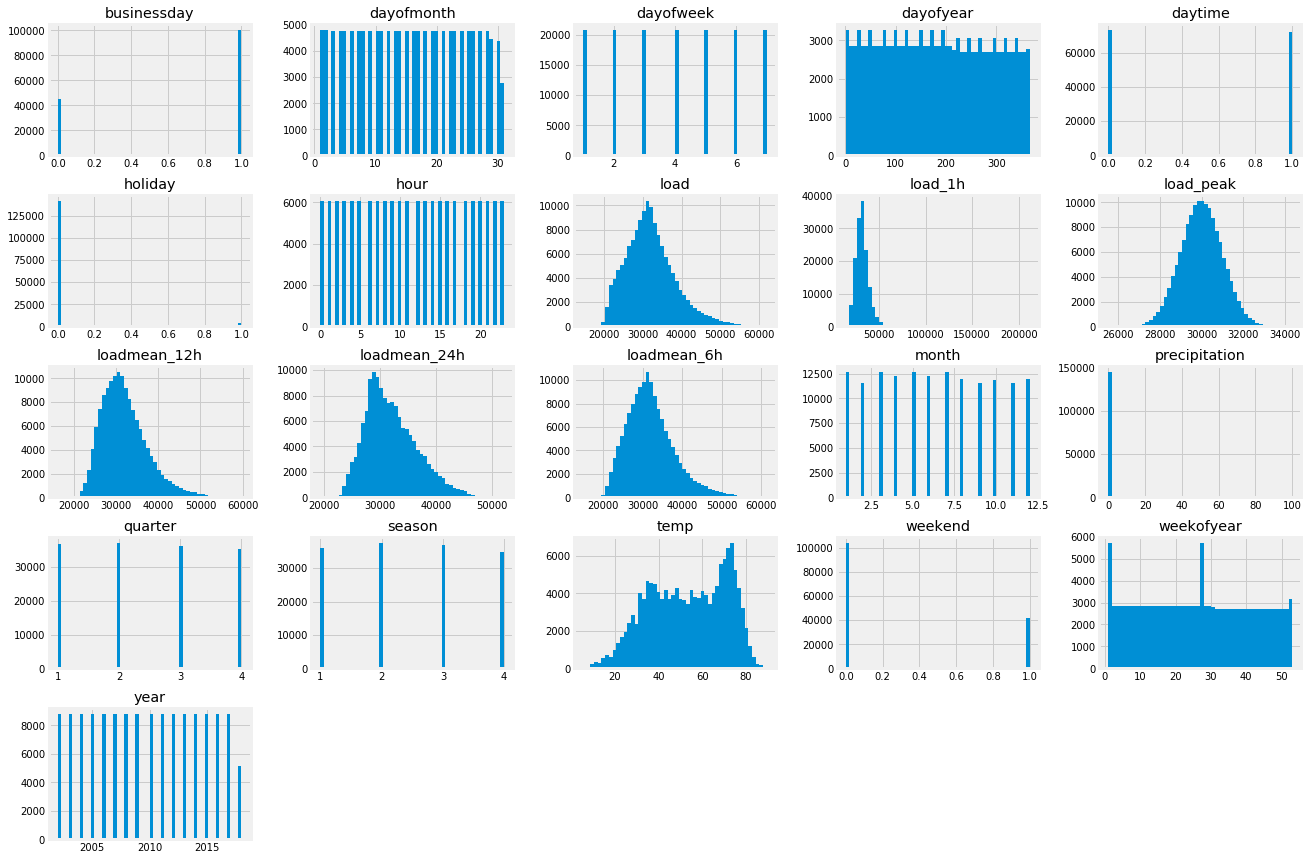

In [13]:
_ = df_full.hist(bins=50, figsize=(20,15))

# 7. Clean the dataset <a class="anchor" id="cleaning"></a>

Let's look closer at our data to see if there are any anomalies that need to be cleaned.

In [14]:
df_full.describe().round(2)

,load,load_1h,loadmean_6h,loadmean_12h,loadmean_24h,load_peak,year,quarter,month,weekofyear,dayofyear,dayofmonth,dayofweek,hour,daytime,weekend,holiday,businessday,season,temp,precipitation
count,145366.00,145361.00,145356.00,145344.00,145320.00,145366.00,145366.00,145366.00,145366.00,145366.00,145366.00,145366.00,145366.0,145366.00,145366.0,145366.00,145366.00,145366.00,145366.00,145366.00,145366.00
mean,32080.22,32083.41,32080.10,32079.84,32079.40,29997.53,2009.80,2.48,6.44,26.21,180.46,15.72,4.0,11.50,0.5,0.29,0.03,0.69,2.49,53.33,0.27
std,6464.01,6504.48,6081.38,5398.05,4684.75,999.35,4.79,1.11,3.44,15.02,105.14,8.80,2.0,6.92,0.5,0.45,0.16,0.46,1.11,17.64,3.86
min,14544.00,14544.00,14970.33,16278.75,19307.42,25543.05,2002.00,1.00,1.00,1.00,1.00,1.00,1.0,0.00,0.0,0.00,0.00,0.00,1.00,5.40,0.00
25%,27573.00,27573.00,27818.17,28165.81,28607.06,29325.48,2006.00,1.00,3.00,13.00,90.00,8.00,2.0,6.00,0.0,0.00,0.00,0.00,2.00,38.60,0.00
50%,31421.00,31421.00,31353.17,31283.04,31327.40,29996.12,2010.00,2.00,6.00,26.00,179.00,16.00,4.0,12.00,0.0,0.00,0.00,1.00,2.00,54.40,0.00
75%,35650.00,35650.00,35364.04,35087.77,34971.71,30670.51,2014.00,3.00,9.00,39.00,271.00,23.00,6.0,18.00,1.0,1.00,0.00,1.00,3.00,69.40,0.07
max,62009.00,211492.00,61410.50,59692.83,52261.42,34338.43,2018.00,4.00,12.00,53.00,366.00,31.00,7.0,23.00,1.0,1.00,1.00,1.00,4.00,89.70,99.99


If we look at the `load_1h` column, the maximum vaue is almost **7x larger** than the mean, where for the other load values the max is about **2x larger** than the mean. Let's look closer at the histogram.

In [15]:
df_full.index = pd.DatetimeIndex(df_full.index)

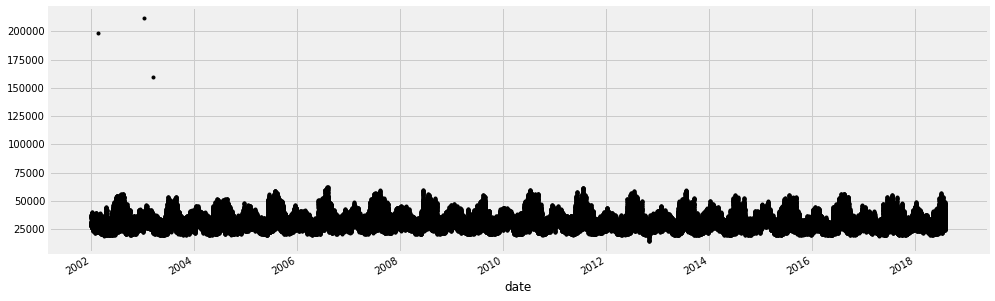

In [16]:
_ = df_full["load_1h"].plot(style='k.', figsize=(15,5))

We can see in the plot above, 3 data points that are outliers. Since they are all in our training set, we should filter them out.

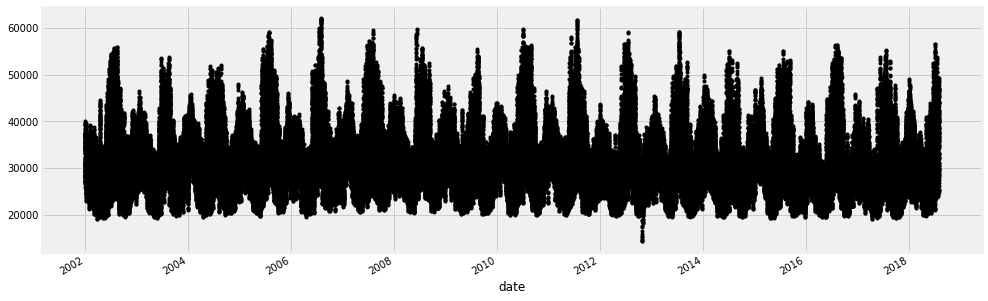

In [17]:
df_full = df_full[df_full['load_1h']<=70000]
_ = df_full["load_1h"].plot(style='k.', figsize=(15,5))

In [18]:
len(df_full.index)-df_full.count()

load              0
load_1h           0
loadmean_6h       8
loadmean_12h     20
loadmean_24h     44
load_peak         0
year              0
quarter           0
month             0
weekofyear        0
dayofyear         0
dayofmonth        0
dayofweek         0
hour              0
daytime           0
weekend           0
holiday           0
businessday       0
season            0
temp              0
precipitation     0
dtype: int64

### How to handle missing values? 

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/missingData.png?raw=true" width="1200">

A simple, and yet effective, way to handling missing values is to simply delete the entire row observation. What would be one downside of this approach?

Another way is to fill the wholes with an "educated guess". Can you think of ways of doing that? (Hint: think statistics!)

In [19]:
df_full = df_full.dropna()
len(df_full.index)-df_full.count()

load             0
load_1h          0
loadmean_6h      0
loadmean_12h     0
loadmean_24h     0
load_peak        0
year             0
quarter          0
month            0
weekofyear       0
dayofyear        0
dayofmonth       0
dayofweek        0
hour             0
daytime          0
weekend          0
holiday          0
businessday      0
season           0
temp             0
precipitation    0
dtype: int64

# 8. Retrain XGBoost model with new features <a class="anchor" id="modelnew"></a>

We can now re train the XGBoost model using the new features to see if performance improves.

Here is a list of available features that can be used in the model.

In [20]:
df_full.drop(columns=['load']).columns

Index(['load_1h', 'loadmean_6h', 'loadmean_12h', 'loadmean_24h', 'load_peak',
       'year', 'quarter', 'month', 'weekofyear', 'dayofyear', 'dayofmonth',
       'dayofweek', 'hour', 'daytime', 'weekend', 'holiday', 'businessday',
       'season', 'temp', 'precipitation'],
      dtype='object')

Select which features you would like to include in the model, and add them to the `include_variables` list bellow.
Then check how the model performs.

In [ ]:
# SELECT A COMBINATION OF FEATURES HERE
include_variables = ['hour', 'dayofyear', 'quarter']
#

split_date = '2015-01-01'
df_full_train = df_full.loc[df_full.index <= split_date].copy()
df_full_test = df_full.loc[df_full.index > split_date].copy()

df_full_test.index = pd.DatetimeIndex(df_full_test.index)
df_full_train.index = pd.DatetimeIndex(df_full_train.index)

reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(df_full_train[include_variables], df_full_train["load"].values.reshape(-1, 1))
df_full_test['load_Prediction_xgb'] = reg.predict(df_full_test[include_variables])
_ = df_full_test[['load','load_Prediction_xgb']].plot(figsize=(15, 5))

### Check how well our model performs
Which Feature gives you the lowest MAE and highest R^2?

In [ ]:
mse = mean_squared_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb'])
print ("The Mean Squared Error (MSE) is ", round(mse, 2), "MW^2")
print ("The Root Mean Squared Error (RMSE) is ", round(np.sqrt(mse), 2), "MW")
print ("The Mean Absolute Error (MAE) is ", round(mean_absolute_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb']), 2), "MW")
print ("The Mean Absolute Percentage Error is ", round(mean_absolute_percentage_error(y_true=df_full_test['load'], y_pred=df_full_test['load_Prediction_xgb']), 2), "%")
print ("The R^2 (coefficient of determination) regression score is ", round(r2_score(y_true=df_full_test['load'],y_pred=df_full_test['load_Prediction_xgb']), 2))

### Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

In [ ]:
_ = plot_importance(reg, height=0.9)

## 8.1 Look at Worst and Best Predicted Days <a class="anchor" id="bestworst"></a>

In [ ]:
df_full_test['error'] = df_full_test['load'] - df_full_test['load_Prediction_xgb']
df_full_test['abs_error'] = df_full_test['error'].apply(np.abs)
error_by_day = df_full_test.groupby(['year','month','dayofmonth']) \
    .mean()[['load','load_Prediction_xgb','error','abs_error']]

### Worst days

In [ ]:
error_by_day.sort_values('abs_error', ascending=False).round(2).head(10)

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)


_ = df_full_test[['load','load_Prediction_xgb']][(df_full_test[['load','load_Prediction_xgb']].index>'2015-02-20') & (df_full_test[['load','load_Prediction_xgb']].index<'2015-02-21')].plot(ax=ax, style=['-','.'])
plot = plt.suptitle('Worst Predicted Day') 

Temperature in worst predicted day

In [ ]:
df_full[df_full.index=='2015-02-20 00:00:00']['temp'].head()

### Best days

In [ ]:
error_by_day.sort_values('abs_error', ascending=True).round(2).head(10)

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df_full_test[['load','load_Prediction_xgb']][(df_full_test[['load','load_Prediction_xgb']].index>'2018-05-17') & (df_full_test[['load','load_Prediction_xgb']].index<'2018-05-18')].plot(ax=ax, style=['-','.'])
plot = plt.suptitle('Best Predicted Day')

# 9. Classification - Can we predict if a day is a weekend or a weekday? <a class="anchor" id="classification"></a>


###  $$\hat{f}(w,x) = f\bigg(\sum_{j}w_jx_j\bigg)$$

### $$ \hat{f}(x) = \Bigr\{ { 1 \atop 0}  {if \ \textbf{w} \cdot \textbf{x} \ > \ T\atop \ otherwise} $$


How to divide the classes? | Evaluation
- | - 
<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/xgb.png?raw=true" width="900"> | <img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/PrecRec.jpg?raw=true" width="500">

In [ ]:
df_day = df_full.groupby(['year','month','dayofmonth']).sum()[['load']] \
.join(df_full.groupby(['year','month','dayofmonth']).max()[['temp', 'weekend']], how='inner')
df_day.reset_index(inplace=True)
df_day['date'] = df_day['year'].astype(str) + '-' + df_day['month'].astype(str) + '-' + df_day['dayofmonth'].astype(str)
df_day['date'] = df_day['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_day.index = df_day['date']
df_day = df_day.drop(['year','month','dayofmonth', 'date'], axis=1)
df_day = df_day[df_day['load']>=500000] #remove end of year outliers which don't have 24 hours of data to sum

df_day.head()

In [ ]:
df_day_train = df_day.loc[df_day.index < '2015-01-01'].copy()
df_day_test = df_day.loc[df_day.index >= '2015-01-01'].copy()

X_train = df_day_train[['load', 'temp']]
y_train = df_day_train["weekend"]
X_test = df_day_test[['load', 'temp']]
y_test = df_day_test["weekend"]

In [ ]:
clas = xgb.XGBClassifier(n_estimators=100)
clas.fit(X_train, y_train)
df_day_test['weekend_pred'] = clas.predict(X_test)

In [ ]:
plot_confusion_matrix(df_day_test['weekend'], df_day_test['weekend_pred'], classes=["weekend", "weekday"], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
_ = plot_importance(clas, height=0.9)

### Try it out yourself

Just change the values of the model input variables to get a prediction.

In [ ]:
d = dict({"load":32802,"temp":28.6})

df = pd.DataFrame(d, range(len(d)-1))
pred = clas.predict(df)
pred = 'Weekend' if pred[0] == 1 else 'Weekday'
print(pred)

# 10. K-Means clustering - What are some innate groups in the data? <a class="anchor" id="clustering"></a>

K-means clustering is a classification algorithm used to automatically divide a large group into smaller groups.

The name comes because you choose K groups to split our data into. You take the average of these groups to improve the accuracy of the group. The cluster is just another name for a group, because different groups are said to 'cluster' together.

<img src="https://raw.githubusercontent.com/robmoratore/ShellDnA/master/data/images/k_means.gif" width="400">

In [ ]:
kmeans = KMeans(n_clusters=4).fit(df_day[['temp', 'load']])
centroids = kmeans.cluster_centers_

_ = plt.scatter(df_day['temp'], df_day['load'], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
_ = plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

# 11. What are the next steps? <a class="anchor" id="nextsteps"></a>

<img src="https://github.com/robmoratore/ShellDnA/blob/master/data/images/next_steps.png?raw=true" width="1200">